In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")

from chiseling.dgps.binary_design_rct import BinaryDesignRCT, search_for_target_specification_binary_design_rct
from chiseling.source.learners.baselearners_general import make_lassocv_learner, make_elasticnetcv_learner, make_random_forest_learner
from chiseling.source.protocol.IRST import UnitRegistrar, IRST
from chiseling.source.strategies.alpha_spending_strategy import AlphaSpendingStrategy
from chiseling.source.strategies.data_splitting_strategy import DataSplittingStrategy

In [3]:
# Hyperparameters
n = 5000
d = 150
s = 15
target_size = 0.1
amplifier = 5
theta = 0.2 * amplifier
tau = -1 * amplifier
rho = 0.5

alpha = 0.05

random_seed = 42

In [4]:
p = search_for_target_specification_binary_design_rct(d, s, rho, theta, tau, target_size, np.random.RandomState(random_seed))

In [5]:
# Sample data
sampler = BinaryDesignRCT(d, s, p, rho, theta, tau, ipw_transform=True, random_seed=random_seed)
X, Y = sampler.sample(n)

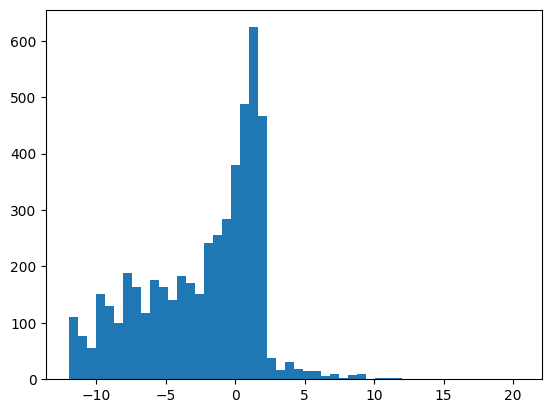

In [6]:
plt.hist(Y, bins=50)
plt.show()

In [7]:
sampler.get_optimal_region_metrics()

(np.float64(0.1893),
 np.float64(0.09976),
 np.float64(1.8975541299117884),
 np.float64(0.0021418345174172536),
 np.float64(0.0009476705250243884),
 np.float64(0.011662981624640334))

In [8]:
# Initialize protocol
unit_reg = UnitRegistrar(random_seed)
regX = unit_reg.register_units(X)
protocol = IRST(regX, Y, alpha=alpha)

In [9]:
# Make LassoCV learner
lassocv_learner = make_lassocv_learner(random_seed=random_seed)

In [10]:
# Run chiseling
strategy = AlphaSpendingStrategy(protocol=protocol,
                                 test_thresh=0,
                                 learner=lassocv_learner,
                                 n_burn_in=0.2,
                                 batch_size=int(0.05 * n),
                                 n_min=30,
                                 alpha_min=1e-3,
                                 alpha_spending_fn='uniform',
                                 tiebreak=False,
                                 use_learner_weights=True,
                                 skip_const_predictor=False,
                                 random_seed=random_seed)

strategy.run_strategy(verbose=True)

METRICS = {'curr_sample_efficiency': 1.0, 'spent_alpha': np.float64(0.0), 'remaining_alpha': np.float64(0.05), 'n_shrink_revealed': 3537, 'n_left_in_region': 463, 'region_mass_estimate': np.float64(0.11574999999999999)}
SUMMARY: rejected = True, spent_alpha = 0.010000000000000009, n_left_in_region = 463, region_mass-estimate = 0.11574999999999999


In [11]:
protocol.testing_history

,stage_number,mean,variance,sample_size,test_stat,alloc_alpha,remaining_alpha,crit_val,rejection
0,-1,-2.342173,17.991118,5000,-39.045858,0.00,0.050000,inf,False
1,16,1.454414,10.149881,463,9.823090,0.01,0.040404,2.326348,True


In [12]:
protocol.protocol_metadata.rev_stage.max()

np.int64(15)

In [13]:
protocol.protocol_metadata[protocol.protocol_metadata.rev_stage == 1]

,orig_ind,pt_order,pseudo_pt_order,rev_stage,is_random,reg_mass_est,unmasking_score,pseudo_reg_mass_est,pseudo_unmasking_score
26,31,1081,105.0,1,False,0.97950,"(-4.60194278371668,)",0.9788,"(-4.60194278371668,)"
30,35,1108,144.0,1,False,0.97275,"(-4.535314446031515,)",0.9710,"(-4.535314446031515,)"
82,92,1048,65.0,1,False,0.98775,"(-4.712188015200548,)",0.9868,"(-4.712188015200548,)"
95,106,1085,110.0,1,False,0.97850,"(-4.601556942558155,)",0.9778,"(-4.601556942558155,)"
119,136,1070,92.0,1,False,0.98225,"(-4.646931915528125,)",0.9814,"(-4.646931915528125,)"
...,...,...,...,...,...,...,...,...,...
4362,4812,1047,64.0,1,False,0.98800,"(-4.723256520761293,)",0.9870,"(-4.723256520761293,)"
4406,4858,1017,29.0,1,False,0.99550,"(-4.936099847891381,)",0.9940,"(-4.936099847891381,)"
4411,4864,1069,91.0,1,False,0.98250,"(-4.647401558748427,)",0.9816,"(-4.647401558748427,)"
4465,4922,1205,258.0,1,False,0.94850,"(-4.370087907669452,)",0.9482,"(-4.370087907669452,)"


In [14]:
# So here's what we got:
# High dimensional binary design, correlated covariates, non-normal errors
# I can set p = 0.5, theta = 0, and tau > 0, rho = 0.5 to showcase the non-heterogeneous setting
# Use both random forest and lasso here, and demonstrate all three alpha spending fns
# Then do optimal size among 75%, 50%, 25%, 10%, 5%, and scale CATE so that power is non-trivial on range n = 1000 to 4000
# Might have to do this last step somewhat manually

# Note: a unit is in optimal region if it possesses at least 6 of the 15 (possibly rare) attributes

# I think we should just have a separate set of simulations for Type I error:
# high dimensional, low dimensional, error distributions, correlated designs, etc.
# maybe this should somewhat subsume the settings that I experiment on

# After this: we do Gaussian design high-dimensional non-sparse logistic regression
# Here, we fix the target risk as 90%, and we shift the logits down to tune the optimal subgroup size